In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import os
import cv2
from tqdm.notebook import tqdm
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet18
from torch import nn

In [26]:
class LoadData:
    def __init__(self, path):
        dirs = os.listdir(path)
        filenames = {0: [path + dirs[0] + '/' + filename for filename in os.listdir(path + dirs[0])],
                     1: [path + dirs[1] + '/' + filename for filename in os.listdir(path + dirs[1])]}

        X_data, y_data = self.read_images(filenames)
        train, valid = self.split_data(X_data, y_data)
        self.train_dataset = self.cvt_to_torch(train[0], train[1])
        self.valid_dataset = self.cvt_to_torch(valid[0], valid[1])

    def read_images(self, filenames):
        X, y = [], []
        for label in filenames.keys():
            for filename in tqdm(filenames[label]):
                img = cv2.imread(filename)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255
                img = img.transpose(2, 0, 1)
                X.append(img)
                y.append(np.expand_dims(label, 0))
        return np.array(X), np.array(y).astype(np.float32)

    def split_data(self, X_data, y_data):
        X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, shuffle=True)
        return (X_train, y_train), (X_valid, y_valid)

    def cvt_to_torch(self, X, y):
        dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
        return dataset

    def get_dataloadet(self):
        train_loader = DataLoader(self.train_dataset, batch_size=16, shuffle=True)
        valid_loader = DataLoader(self.valid_dataset, batch_size=1, shuffle=False)
        return train_loader, valid_loader

    def __del__(self):
        print('object deleted!')


path = '/content/drive/MyDrive/dataset/'
dataloader = LoadData(path)
train_loader, valid_loader = dataloader.get_dataloadet()
del dataloader

for X, y in train_loader:
    print(X.size(), y.size())
    break

  0%|          | 0/2871 [00:00<?, ?it/s]

  0%|          | 0/2999 [00:00<?, ?it/s]

object deleted!
torch.Size([16, 3, 119, 119]) torch.Size([16, 1])


In [54]:
class BinaryResnet(nn.Module):
    def __init__(self):
        super(BinaryResnet, self).__init__()
        self.resnet = resnet18(pretrained=False)
        self.resnet.fc = nn.Linear(512, 1, bias=True)
        self.activate = nn.Sigmoid()

    def forward(self, x):
        x = self.resnet.forward(x)
        x = self.activate(x)
        return x

model = BinaryResnet()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [55]:
mean_train_loss, mean_valid_loss = [], []

In [62]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.BCELoss()
epochs = 5
for epoch in range(epochs):
    accuracy = 0
    train = iter(train_loader)
    valid = iter(valid_loader)
    tmp_train_loss, tmp_valid_loss = [], []
    for i in tqdm(range(len(train))):
        optimizer.zero_grad()
    # Forward
        X, y = next(train)
        X, y = X.to(device), y.to(device)
        y_pred = model.forward(X)
        

    # Calculate loss
        loss = criterion(y_pred, y)

    # Backward
        loss.backward()

    # Update weigths
        optimizer.step()

    # Validation
        with torch.no_grad():
            X_valid, y_valid = next(valid)
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)
            y_valid_pred = model.forward(X_valid)
            loss_valid = criterion(y_valid_pred, y_valid)
    # Udpate metrics
            tmp_train_loss.append(loss.item())
            tmp_valid_loss.append(loss_valid.item())

            tmp_pred = 1 if y_valid_pred >= 0.5 else 0
            if tmp_pred == y_valid:
                accuracy += 1

    torch.cuda.empty_cache()
    train_loss = sum(tmp_train_loss) / len(tmp_train_loss)
    valid_loss = sum(tmp_valid_loss) / len(tmp_valid_loss)
    mean_train_loss.append(train_loss)
    mean_valid_loss.append(valid_loss)
    print(f'epoch: {epoch + 1}, train loss: {train_loss}', 
    f'valid loss = {valid_loss}, acc: {accuracy /len(train)}')

    
        

  0%|          | 0/276 [00:00<?, ?it/s]

epoch: 1, train loss: 0.0009397357804358387 valid loss = 0.121767309507814, acc: 0.9963768115942029


  0%|          | 0/276 [00:00<?, ?it/s]

epoch: 2, train loss: 2.3265142155661007e-05 valid loss = 0.12171024243360844, acc: 0.9963768115942029


  0%|          | 0/276 [00:00<?, ?it/s]

epoch: 3, train loss: 2.2602467526957152e-05 valid loss = 0.1217044739295607, acc: 0.9963768115942029


  0%|          | 0/276 [00:00<?, ?it/s]

epoch: 4, train loss: 0.00044338708192445876 valid loss = 0.12170206107523131, acc: 0.9963768115942029


  0%|          | 0/276 [00:00<?, ?it/s]

epoch: 5, train loss: 0.003242003608443897 valid loss = 0.12116142475734586, acc: 0.9963768115942029


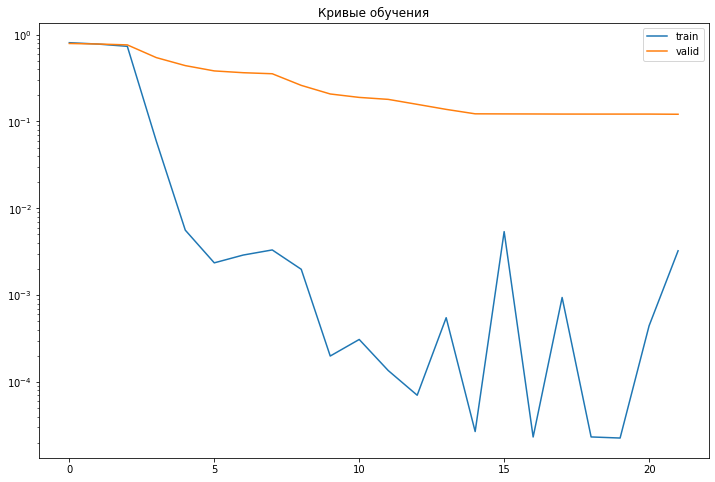

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(mean_train_loss)
plt.plot(mean_valid_loss)
plt.title('Кривые обучения')
plt.yscale('log')
plt.legend(['train', 'valid'])
plt.show()

In [68]:
torch.save(model.state_dict(), 'model_weights.pth')